In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.transforms import ToTensor

from sklearn.metrics import classification_report, confusion_matrix


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [5]:
DATASET_ROOT = r"F:\Project\GPU\brain2"

In [6]:
import shutil

input_root = DATASET_ROOT
output_root = r"F:\Project\GPU\brain2_gaussian"

os.makedirs(output_root, exist_ok=True)

splits = ["Training", "Testing"]

for split in splits:
    for cls in os.listdir(os.path.join(input_root, split)):
        in_dir = os.path.join(input_root, split, cls)
        out_dir = os.path.join(output_root, split, cls)
        os.makedirs(out_dir, exist_ok=True)
        
        for img_name in os.listdir(in_dir):
            img_path = os.path.join(in_dir, img_name)
            img = cv2.imread(img_path)

            blur = cv2.GaussianBlur(img, (5,5), 0)
            cv2.imwrite(os.path.join(out_dir, img_name), blur)

print("Gaussian preprocessing done!")


Gaussian preprocessing done!


In [7]:
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root = root_dir
        self.transform = transform
        
        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []
        
        for idx, cls in enumerate(self.classes):
            paths = glob(os.path.join(root_dir, cls, "*.jpg")) + \
                    glob(os.path.join(root_dir, cls, "*.png"))
            
            self.image_paths.extend(paths)
            self.labels.extend([idx]*len(paths))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        img_path = self.image_paths[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform:
            img = self.transform(img)

        return img, self.labels[index]


In [8]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

train_dataset = BrainTumorDataset(
    root_dir=os.path.join(output_root, "Training"),
    transform=train_transform
)

test_dataset = BrainTumorDataset(
    root_dir=os.path.join(output_root, "Testing"),
    transform=test_transform
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [9]:
model = models.efficientnet_b0(weights="IMAGENET1K_V1")

num_classes = 4  # glioma, meningioma, notumor, pituitary

model.classifier[1] = nn.Linear(1280, num_classes)
model = model.to(device)


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [11]:
def train_model(model, loader):
    model.train()
    total, correct, epoch_loss = 0, 0, 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    return epoch_loss / len(loader), acc


In [12]:
def eval_model(model, loader):
    model.eval()
    total, correct = 0, 0
    preds_list = []
    true_list = []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)

            _, preds = torch.max(outputs, 1)
            preds_list.extend(preds.cpu().numpy())
            true_list.extend(labels.cpu().numpy())

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = 100 * correct / total
    return acc, preds_list, true_list


In [14]:
EPOCHS = 10

for epoch in range(EPOCHS):
    train_loss, train_acc = train_model(model, train_loader)
    test_acc, _, _ = eval_model(model, test_loader)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")


Epoch 1/10
Train Loss: 0.1871 | Train Acc: 93.84% | Test Acc: 97.64%
Epoch 2/10
Train Loss: 0.0951 | Train Acc: 96.78% | Test Acc: 99.08%
Epoch 3/10
Train Loss: 0.0628 | Train Acc: 98.07% | Test Acc: 98.93%
Epoch 4/10
Train Loss: 0.0463 | Train Acc: 98.49% | Test Acc: 99.08%
Epoch 5/10
Train Loss: 0.0359 | Train Acc: 98.76% | Test Acc: 99.01%
Epoch 6/10
Train Loss: 0.0282 | Train Acc: 99.04% | Test Acc: 99.54%
Epoch 7/10
Train Loss: 0.0237 | Train Acc: 99.14% | Test Acc: 99.16%
Epoch 8/10
Train Loss: 0.0214 | Train Acc: 99.23% | Test Acc: 99.54%
Epoch 9/10
Train Loss: 0.0300 | Train Acc: 99.02% | Test Acc: 99.54%
Epoch 10/10
Train Loss: 0.0231 | Train Acc: 99.18% | Test Acc: 99.85%


In [15]:
test_acc, preds, trues = eval_model(model, test_loader)

print("Test Accuracy:", test_acc)
print(classification_report(trues, preds, target_names=train_dataset.classes))


Test Accuracy: 99.84744469870328
              precision    recall  f1-score   support

      glioma       1.00      1.00      1.00       300
  meningioma       0.99      1.00      1.00       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      0.99      1.00       300

    accuracy                           1.00      1311
   macro avg       1.00      1.00      1.00      1311
weighted avg       1.00      1.00      1.00      1311



In [16]:
torch.save(model.state_dict(), "brain_tumor_classifier.pth")


In [17]:
def predict_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    tensor = test_transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(tensor)
        _, pred = torch.max(output, 1)

    return train_dataset.classes[pred.item()]



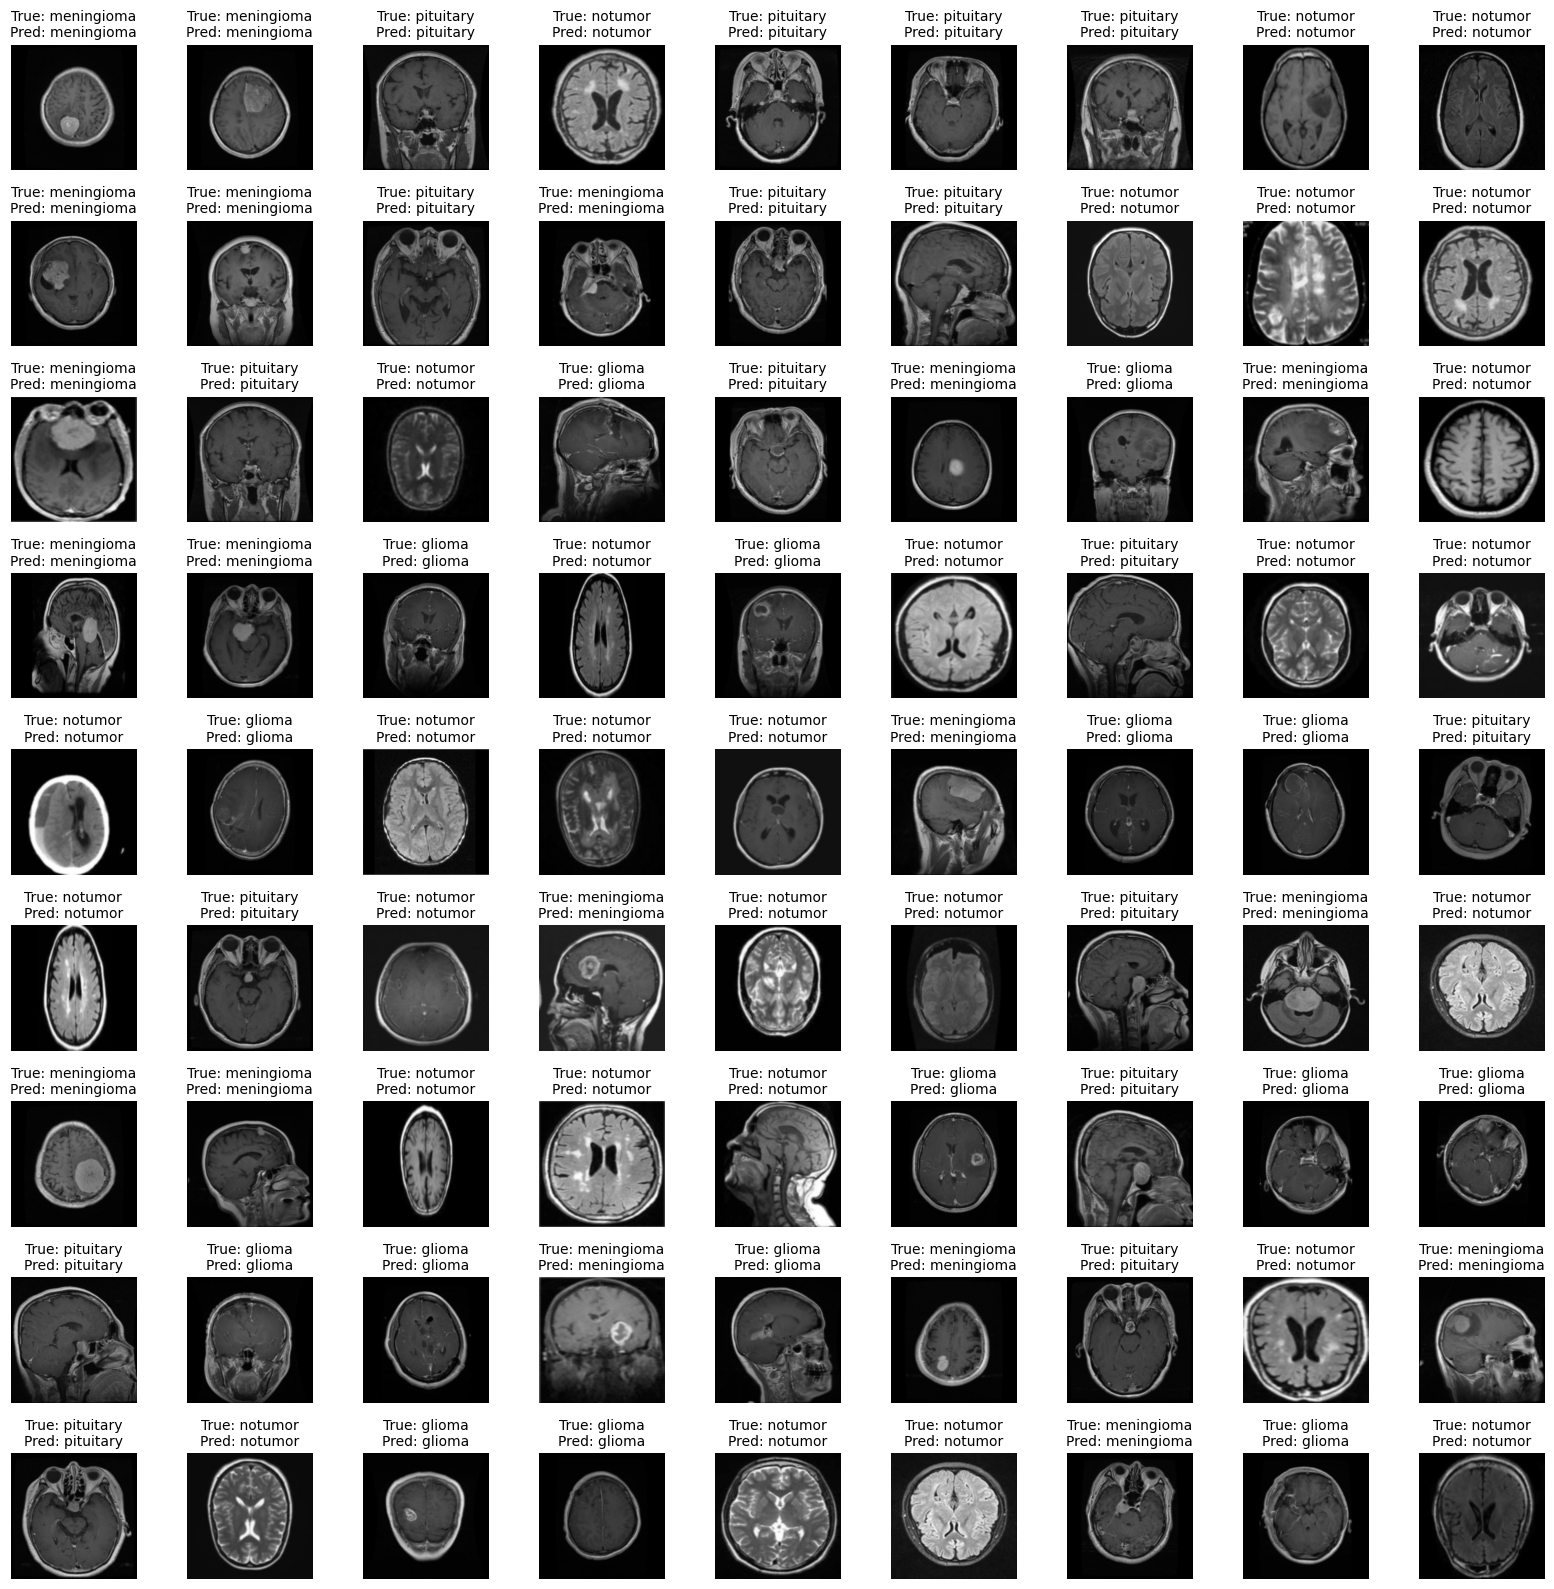

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Make sure model is in evaluation mode
model.eval()

# Step 1: Collect all test images + preds
all_images = []
all_true_labels = []
all_pred_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        
        # Move tensors to CPU
        imgs = imgs.cpu().numpy()
        labels = labels.cpu().numpy()
        preds = preds.cpu().numpy()

        # Convert CHW → HWC
        imgs = np.transpose(imgs, (0, 2, 3, 1))

        all_images.extend(imgs)
        all_true_labels.extend(labels)
        all_pred_labels.extend(preds)

all_images = np.array(all_images)
all_true_labels = np.array(all_true_labels)
all_pred_labels = np.array(all_pred_labels)

# Step 2: Randomly select 81 images
indices = np.random.choice(len(all_images), 81, replace=False)

selected_images = all_images[indices]
selected_true_labels = all_true_labels[indices]
selected_pred_labels = all_pred_labels[indices]

categories = train_dataset.classes   # ['glioma','meningioma','notumor','pituitary']

# Step 3: Plot 9×9 grid
fig, axes = plt.subplots(9, 9, figsize=(16, 16))
axes = axes.ravel()

for i in range(81):
    axes[i].imshow(selected_images[i])
    
    true_label = categories[selected_true_labels[i]]
    pred_label = categories[selected_pred_labels[i]]
    
    axes[i].set_title(
        f'True: {true_label}\nPred: {pred_label}', 
        fontsize=10
    )
    axes[i].axis('off')

plt.tight_layout()
plt.show()


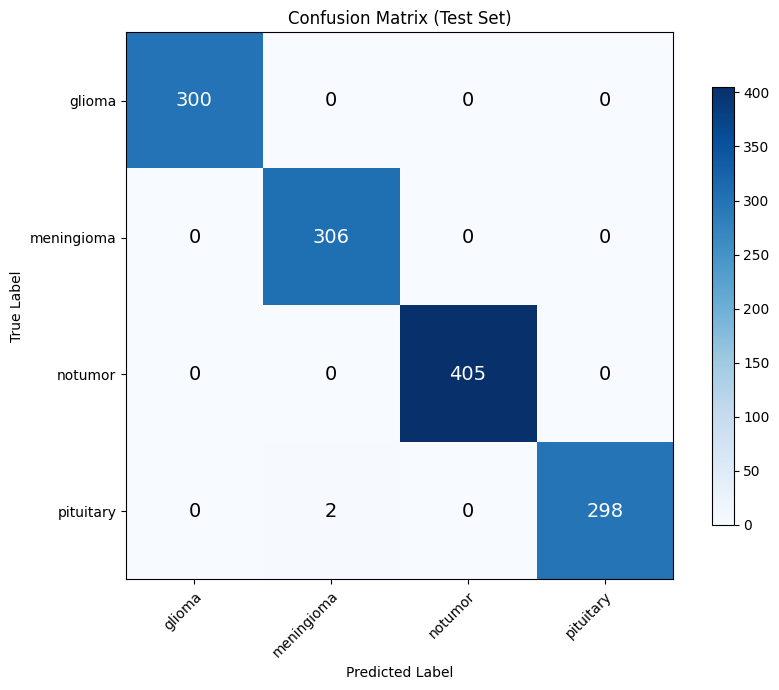

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns  # optional, but makes it prettier (you already have matplotlib)

cm = confusion_matrix(all_trues, all_preds)

fig, ax = plt.subplots(figsize=(9, 7))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.figure.colorbar(im, ax=ax, shrink=0.8)

# Labels
classes = train_dataset.classes
ax.set(xticks=np.arange(len(classes)),
       yticks=np.arange(len(classes)),
       xticklabels=classes,
       yticklabels=classes,
       title='Confusion Matrix (Test Set)',
       ylabel='True Label',
       xlabel='Predicted Label')

# Rotate x labels for readability
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add numbers inside cells
thresh = cm.max() / 2.
for i in range(len(classes)):
    for j in range(len(classes)):
        ax.text(j, i, cm[i, j],
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=14)

plt.tight_layout()
plt.show()


COMPUTING ROC-AUC & PLOTTING CURVES
ROC AUC (One-vs-Rest, macro) : 0.99998
ROC AUC (One-vs-One, macro)  : 0.99998


f:\Project\GPU\venv\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
f:\Project\GPU\venv\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
f:\Project\GPU\venv\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
f:\Project\GPU\venv\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


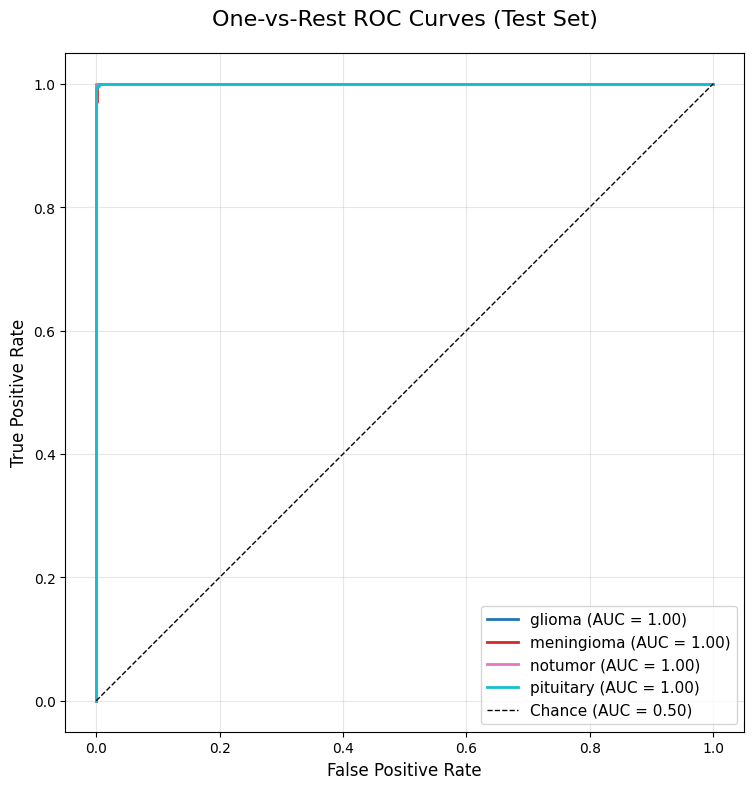

In [30]:
# 6. Multi-class ROC-AUC + ROC Curves (Fixed & Efficient)
print("\n" + "="*60)
print("COMPUTING ROC-AUC & PLOTTING CURVES")
print("="*60)

model.eval()
all_probs = []
all_trues_roc = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        
        all_probs.append(probs.cpu().numpy())
        all_trues_roc.append(labels.numpy())

# Concatenate all batches
y_score = np.concatenate(all_probs)        # shape: (1311, 4)
y_true_onehot = np.eye(n_classes)[np.concatenate(all_trues_roc)]

# Compute AUC
auc_ovr = roc_auc_score(y_true_onehot, y_score, multi_class='ovr', average='macro')
auc_ovo = roc_auc_score(y_true_onehot, y_score, multi_class='ovo', average='macro')

print(f"ROC AUC (One-vs-Rest, macro) : {auc_ovr:.5f}")
print(f"ROC AUC (One-vs-One, macro)  : {auc_ovo:.5f}")

# Plot beautiful ROC curves
fig, ax = plt.subplots(figsize=(10, 8))
colors = plt.cm.tab10(np.linspace(0, 1, n_classes))

for i, (class_name, color) in enumerate(zip(classes, colors)):
    RocCurveDisplay.from_predictions(
        y_true_onehot[:, i],
        y_score[:, i],
        name=class_name,
        color=color,
        ax=ax,
        linewidth=2
    )

plt.plot([0, 1], [0, 1], "k--", linewidth=1, label="Chance (AUC = 0.50)")
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("One-vs-Rest ROC Curves (Test Set)", fontsize=16, pad=20)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.axis("square")
plt.tight_layout()
plt.show()